In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from cesium import featurize
import sqlite3
from astropy.stats import sigma_clip as sc
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as GridSpec
import glob
import matplotlib.transforms as mtransforms
import matplotlib as mpl

%matplotlib notebook

# AAM efforts

Here I am going to attempt to improve the uncertainty measurements and create a nice looking plot for our Zooniverse effort.

In [8]:
def strateva(mag, a = 0.027665,
             b = 1.285193044293278e-09,
             c = 1.0999892234090642e-19):
    return a + b*10**(0.4*mag) + c*10**(0.8*mag)

In [9]:
def lc_breaks(time, break_width=45):
    breaks = np.where(np.diff(time[np.argsort(time)]) > break_width)
    return breaks

In [65]:
scale_p = mpl.colors.LogNorm(vmin=.1, vmax=1000)
def lognorm(x):
    if x>1000:
        x=1000
    if x<0.31622776601683794:
        x=0.31622776601683794
    return (np.log10(x)+1)/5

In [62]:
def aam_plot(time, mag, mag_unc, filt_id,
             period=1, dpi = 300):
    """Plot a light curve suitable for Zooniverse classification
    """

    color_dict = {1: "LightSeaGreen",
                  2: "Crimson",
                  'c': "DarkTurquoise",
                  'o': "DarkOrange"}
    
    
    model_unc = strateva(mag)
    mean_mag = np.mean(mag)
    
    obs_breaks = lc_breaks(time)[0] + 1
    seasons = len(obs_breaks) + 1
    season_dict = {}
    total_obs_duration = 0
    if len(obs_breaks) > 0:   
        for season_num in range(seasons):
            if season_num == 0:
                season = time[np.argsort(time)][0:obs_breaks[season_num]]
            elif season_num == seasons - 1:
                season = time[np.argsort(time)][obs_breaks[season_num-1]:]
            else:
                season = time[np.argsort(time)][obs_breaks[season_num-1]:obs_breaks[season_num]]

            season_dict["start{:d}".format(season_num)] = min(season)
            season_dict["end{:d}".format(season_num)] = max(season)
            season_dict["length{:d}".format(season_num)] = np.round(np.ptp(season)) + 2
            total_obs_duration += season_dict["length{:d}".format(season_num)]
    elif len(obs_breaks) == 0:
        season = time[np.argsort(time)]
        
        season_dict["start{:d}".format(0)] = min(season)
        season_dict["end{:d}".format(0)] = max(season)
        season_dict["length{:d}".format(0)] = np.round(np.ptp(season)) + 2
        total_obs_duration += season_dict["length{:d}".format(0)]
        
        
    
    ###### FIGURE #######    
    plot_gap = np.round(0.01*total_obs_duration/(1 - 0.01*len(obs_breaks))).astype(int)

    fig = plt.figure(figsize=(7,5.75), dpi = dpi)

    gs = GridSpec.GridSpec(4, int(total_obs_duration) + len(obs_breaks)*plot_gap)



    amplitude = np.ptp(mean_mag - mag)
    offset = [0.25, -0.25]
#     raw_ymin = min(mean_mag - mag) - 0.05*amplitude
#     ymin = min(raw_ymin, np.around(raw_ymin,decimals=2))
#     raw_ymax = max(mean_mag - mag) + 0.05*amplitude
#     ymax = max(raw_ymax, np.around(raw_ymax,decimals=2))
    
    if amplitude > 0.5:
        ymajor = np.round(amplitude)/4
        yminor = np.round(amplitude)/20
    elif amplitude < 0.2:
        ymajor = 0.05
        yminor = 0.01
    else:
        ymajor = 0.1
        yminor = 0.02

            
    amps = np.zeros(2)
    new_ymin = 10
    new_ymax = 0

    for c, filt in enumerate(np.unique(filt_id)):
        infilt = np.where(filt_id == filt)
        mean_mag = np.mean(mag[infilt])
        amps[c] = np.ptp(mean_mag - mag[infilt])/2

    for c, filt in enumerate(np.unique(filt_id)):
        infilt = np.where(filt_id == filt)
        mean_mag = np.mean(mag[infilt])

        raw_ymin = min(mean_mag - mag[infilt] + (offset[c] - 0.1) * max(amps))
        new_ymin = min(raw_ymin, np.around(raw_ymin, decimals=2), new_ymin)


        raw_ymax = max(mean_mag - mag[infilt] + (offset[c] + 0.1) * max(amps))
        new_ymax = max(raw_ymax, np.around(raw_ymax,decimals=2), new_ymax)


    for season_num in range(seasons):
        obs_length = season_dict["length{:d}".format(season_num)]
        obs_start = season_dict["start{:d}".format(season_num)]
        obs_end = season_dict["end{:d}".format(season_num)]

        if season_num == 0:
            ax_start = 0
            ax_end = int(obs_length)
        else:
            ax_start = ax_end + plot_gap
            ax_end = ax_start + int(obs_length)
        ax = plt.subplot(gs[0, ax_start:ax_end])
        obs_this_season = np.logical_and(time >= obs_start,
                                         time <= obs_end)
        
        for c, filt in enumerate(np.unique(filt_id[obs_this_season])):
            infilt = np.where(filt_id[obs_this_season] == filt)
            ax.errorbar(time[obs_this_season][infilt] - 54900.5, 
                         np.mean(mag[np.where(filt_id == filt)]) - mag[obs_this_season][infilt] + offset[c] * max(amps), 
                         yerr=model_unc[obs_this_season][infilt], 
                         fmt="o", ms=4, mfc=color_dict[filt], 
                         ecolor=color_dict[filt], elinewidth=0.5,
                         mec="0.2", mew=0.2)
            
        ax.set_xlim(obs_start - 1 - 54900.5, obs_end + 1 - 54900.5)
        ax.tick_params(which="both", top=True, right=False,
                       labelbottom=False, labeltop=True,
                       labelsize=10)
        ax.tick_params(axis="x", labelrotation=25, 
                       labelsize=8, length=5, pad=0)

        if obs_length < 10:
            tick_val = np.around(np.floor(obs_start) + np.ceil(obs_length/2) - 54900.5, decimals=0)
            ax.set_xticks([tick_val])
        elif 10 < obs_length < 50:
            tick_val = np.around(obs_start + np.ceil(obs_length/2) - 54900.5, decimals=-1)
            ax.set_xticks([tick_val])
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        elif 50 < obs_length < 200:
            ax.xaxis.set_major_locator(MultipleLocator(50))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        if 200 < obs_length:
            ax.xaxis.set_major_locator(MultipleLocator(100))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), 
                           ha='left')


        if season_num == 0:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.set_ylabel(r"$\mathrm{Brightness}\,\longrightarrow$")

        elif season_num == seasons-1:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.tick_params(which="both", axis="y", right=True,
                           left=False, labelleft=False)            
        else:
            ax.set_yticks([])
            ax.set_yticks([], minor=True)
            
        ax.set_ylim(new_ymin, new_ymax)

    ax_phase = plt.subplot(gs[1:, :])
    for repeat in [-1, 0, 1]:
        for c, filt in enumerate(np.unique(filt_id)):
            infilt = np.where(filt_id == filt)

            ax_phase.errorbar((time[infilt]/period) % 1 + repeat, 
                              np.mean(mag[infilt]) - mag[infilt] + offset[c] * max(amps), 
                              yerr=model_unc[infilt], 
                              fmt="o", ms=9, mfc=color_dict[filt], 
                              ecolor=color_dict[filt], elinewidth=0.5,
                              mec="0.2", mew=0.4, alpha=0.95)
#             ax_phase.axhline(y = offset[c] * max(amps), ls = '--', color = color_dict[filt], lw=1, zorder = 10)
            
    
    ax_phase.axvline(x=0, ls='--', color='0.8', lw=1)
    ax_phase.axvline(x=1, ls='--', color='0.8', lw=1)
    ax_phase.set_xlim(-0.2,1.2)
    ax_phase.yaxis.set_major_locator(MultipleLocator(ymajor))
    ax_phase.yaxis.set_minor_locator(MultipleLocator(yminor))
    
    ax_phase.set_ylim(new_ymin, new_ymax)
    
    ax_phase.xaxis.set_major_locator(MultipleLocator(0.2))
    ax_phase.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_phase.tick_params(which="both", top=True, right=True, labelsize=11)

    ax_phase.text(0.5, 1.44, "Time (d)", 
                  va="bottom", ha="center",
                  transform = ax_phase.transAxes)
    ax_phase.text(-0.145, 0.5, r"$\mathrm{Brightness}\,\longrightarrow$", 
                  fontsize=16,
                  va="center", ha="left", rotation=90,
                  transform = ax_phase.transAxes)
    ax_phase.text(0.5, -.155, r"Phase", 
                  fontsize=16,
                  va="bottom", ha="center",
                  transform = ax_phase.transAxes)
    
    ax_phase.text(0.86, 0.95, f"p={period:5.3f}", transform = ax_phase.transAxes)
    fig.patches.extend([plt.Rectangle((0.14,0.7), lognorm(period), 0.022,
                                  fill=True, color=mpl.cm.RdYlGn_r(scale_p(period)), zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
    
    fig.subplots_adjust(hspace=0.2, top=0.9,right=0.94,left=0.14,bottom=0.11)
    trans = mtransforms.blended_transform_factory(ax_phase.transData, ax_phase.transAxes)
    ax_phase.fill_between(np.arange(-0.2,0.01,0.01), 0, 1, alpha = 0.35, facecolor = 'grey', transform = trans)
    ax_phase.fill_between(np.arange(1,1.21,0.01), 0, 1, alpha = 0.35, facecolor = 'grey', transform = trans)
    plt.gca().get_xticklabels()[2].set_fontsize(15)
    plt.gca().get_xticklabels()[2].set_weight('bold')
    plt.gca().get_xticklabels()[-3].set_fontsize(15)
    plt.gca().get_xticklabels()[-3].set_weight('bold')
    return fig

In [40]:
mpl.cm.RdYlGn_r(1)

(0.003998462129950019, 0.41522491349480967, 0.21953094963475586, 1.0)

In [41]:
mpl.cm.RdYlGn_r(.1)

(0.09996155324875047, 0.5923875432525951, 0.3118031526336025, 1.0)

In [12]:
filename = "./test_lcs/27882110006813.ipac_tbl"
ipac_lc = Table.read(filename, format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])
fid = np.array(ipac_lc['fid'])

reasonable = np.logical_or((mag < 10),(mag > 23))
clipped_obs = np.copy(reasonable)
clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                           mag[~clipped_obs], 
                                           mag_unc[~clipped_obs], 
                                           features_to_use=["freq1_freq", 
                                                            "amplitude", 
                                                            "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

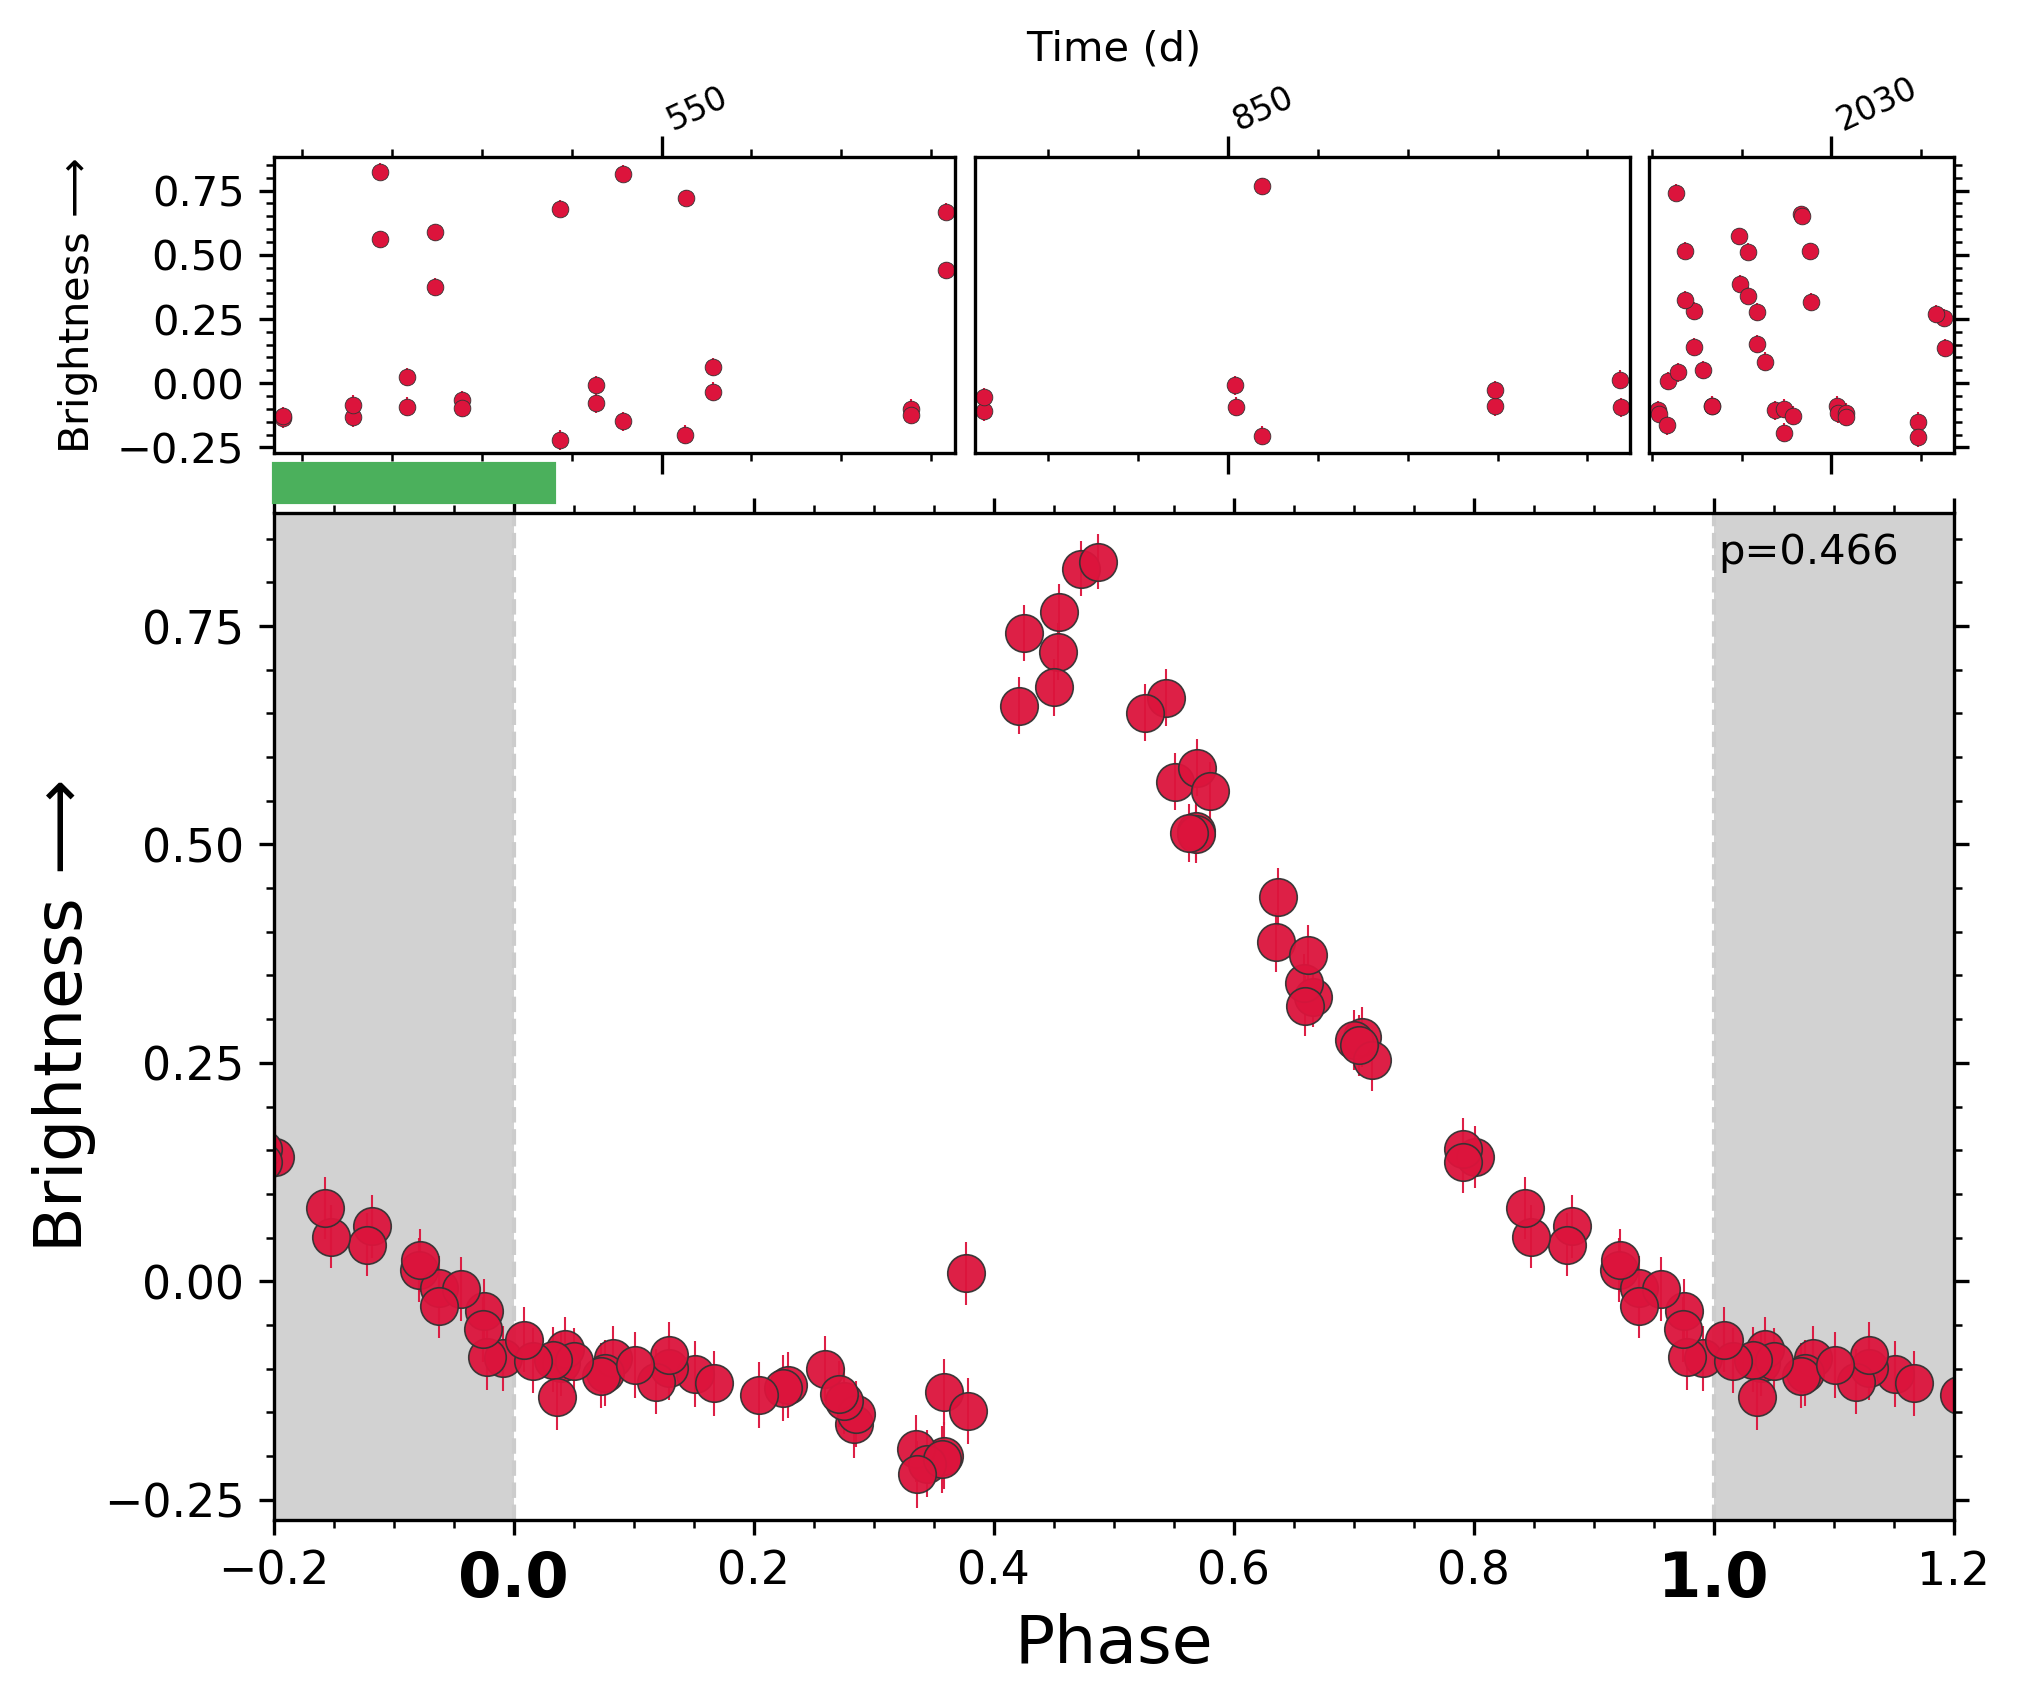

In [70]:
fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period, filt_id = fid[~clipped_obs])
#plt.savefig('test.png', dpi = 300)

In [6]:
# test_lcs = glob.glob("./atlasquerytoptf.csv")
# atlas_lcs = Table.read(test_lcs[0], format = 'csv')

# test_lcs = glob.glob("./ptfallobjects.tbl")
# ptf_lcs = Table.read(test_lcs[0], format = 'ipac')


test_lcs = glob.glob("./atlasquerytoptf.csv")
atlas_lcs = Table.read(test_lcs[0], format = 'csv')

test_lcs = glob.glob("./ptfobjsfromatlas.tbl")
ptf_lcs = Table.read(test_lcs[0], format = 'ipac')

In [156]:
lc = Table.read('./Mira2.csv', format = 'csv')

In [ ]:
import os

In [ ]:
if len(glob.glob('./ComparisonPlots2/*.png')) > 12:
    for fl in glob.glob('./ComparisonPlots2/*.png'):
        os.remove(fl)

In [5]:
rand = np.random.randint(0,1886, 400)
exist = glob.glob('./ComparisonPlots2/*.png')

In [42]:
csvcurves = glob.glob('./NewCurves/*.csv')
tblcurves = glob.glob('./NewCurves/*.tbl')

In [157]:
for obj in np.unique(lc['objid']):
    atlwhere = np.where(lc['objid'] == obj)
    if len(atlwhere) < 20:
        hjd = np.array(lc[atlwhere]['mjd'])
        mag = np.array(lc[atlwhere]['m'])
        mag_unc = np.array(lc[atlwhere]['dm'])
        filters = np.array([byte for byte in lc[atlwhere]['filter']])

        reasonable = np.logical_or((mag < 10),(mag > 23))
        clipped_obs = np.copy(reasonable)
        clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

        filt = np.where(filters[~clipped_obs] == 'c')
        cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                               mag[~clipped_obs][filt], 
                                                               mag_unc[~clipped_obs][filt], 
                                                               features_to_use=["freq1_freq", 
                                                                                "amplitude",
                                                                                "freq1_amplitude1"])

        period_atlces_o = 1/float(cs_feats['freq1_freq'][0])

        fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
              period = period_atlces_o)
        fig.savefig(f'./FieldGuide/mira_{obj}.png', dpi = 300)
        plt.close(fig)

In [43]:
for file in tblcurves:
    lc = Table.read(file, format = 'ipac')
    
    hjd = np.array(lc['obsmjd'])
    mag = np.array(lc['mag_autocorr'])
    mag_unc = np.array(lc['magerr_auto'])
    filters = np.array(lc['fid'])
    
    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
    
    filt = np.where(lc[~clipped_obs]['fid'] == 2)
    cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                           mag[~clipped_obs][filt], 
                                                           mag_unc[~clipped_obs][filt], 
                                                           features_to_use=["freq1_freq", 
                                                                            "amplitude", 
                                                                            "freq1_amplitude1"])
    
    period_atlces_o = 1/float(cs_feats['freq1_freq'][0])

#     filt = np.where(lc[~clipped_obs]['filter'] == 'c')
#     cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
#                                                            mag[~clipped_obs][filt], 
#                                                            mag_unc[~clipped_obs][filt], 
#                                                            features_to_use=["freq1_freq", 
#                                                                             "amplitude", 
#                                                                             "freq1_amplitude1"])

#     period_atlces_c = 1/float(cs_feats["freq1_freq"][0])

#     isclose = math.isclose(period_atlces_o, period_atlces_c, rel_tol = min(period_atlces_o, period_atlces_c)/np.ptp(hjd))
#     if (isclose == True):
#         fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
#           period = period_atlces_o)
#         fig.savefig(f'./FieldGuide/{file.rsplit("/")[2].rsplit(".")[0]}_atlas_o_true.png', dpi = 300)
#         plt.close(fig)
#     elif (isclose == False) and (period != 1):
#         fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
#           period = period_atlces_o)
#         fig.savefig(f'./FieldGuide/{file.rsplit("/")[2].rsplit(".")[0]}_atlas_o_false.png', dpi = 300)
#         plt.close(fig)

    fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
          period = period_atlces_o)
    fig.savefig(f'./FieldGuide/{file.rsplit("/")[2].rsplit(".")[0]}_ptf.png', dpi = 300)
    plt.close(fig)

In [12]:
# pers = Table(names = ('ptf cesium', 'atlas period', 'atlas cesium o', 'atlas cesium c', 'oid', 'objid'))

for c, objs in enumerate(np.unique(atlas_lcs['objid'])):
    if (len(ptf_lcs[np.where(ptf_lcs['objid_01'] == objs)]) > 20) and (c in rand):
#     if (c in rand[0:4]) and (len(ptf_lcs[np.where(ptf_lcs['objid_01'] == objs)]) > 20) and \
#         (objs not in [int(string.rsplit('/')[2].rsplit('_')[0]) for string in exist]):
        atlwhere = np.where(atlas_lcs['objid'] == objs)
        ptfwhere = np.where(ptf_lcs['objid_01'] == objs)
        oid = np.unique(ptf_lcs['oid'][ptfwhere][0])


        hjd = np.array(ptf_lcs[ptfwhere]["obsmjd"])
        mag = np.array(ptf_lcs[ptfwhere]["mag_autocorr"])
        mag_unc = np.array(ptf_lcs[ptfwhere]["magerr_auto"])
        filters = np.array(ptf_lcs[ptfwhere]['fid'])


        reasonable = np.logical_or((mag < 10),(mag > 23))
        clipped_obs = np.copy(reasonable)
        clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

        filt = np.where(ptf_lcs[ptfwhere][~clipped_obs]['fid'] == 2)
        try:
            cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                           mag[~clipped_obs][filt], 
                                                           mag_unc[~clipped_obs][filt], 
                                                           features_to_use=["freq1_freq", 
                                                                            "amplitude", 
                                                                            "freq1_amplitude1"])
            period = 1/float(cs_feats["freq1_freq"][0])
        except:
            period = 1
#             pers[0].append(period)

#         except:
#             period = -999
#             pers[0].append(-999)
        fig1 = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
                 period=period)

        #Atlas data with Cesium period
        hjd = np.array(atlas_lcs[atlwhere]["mjd"])
        mag = np.array(atlas_lcs[atlwhere]["m"])
        mag_unc = np.array(atlas_lcs[atlwhere]["dm"])
        filters = np.array(atlas_lcs[atlwhere]['filter'])


        reasonable = np.logical_or((mag < 10),(mag > 23))
        clipped_obs = np.copy(reasonable)
        clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

#         fig2 = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
#                  period=period)
#         fig2.text(0.5, 0, f'Cesium period on Atlas: {period:.7}', fontsize = 14, horizontalalignment = 'center')

        #Atlas with their period
#         if atlas_lcs[atlwhere]['fp_shortfit'][0] == 0:
#             atlasperiod = atlas_lcs[atlwhere]['fp_lngfitper'][0]
#             short = False
#         elif atlas_lcs[atlwhere]['fp_shortfit'][0] == 1:
#             atlasperiod = atlas_lcs[atlwhere]['fp_period'][0]
#             short = True
#         fig3 = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
#                  period=atlasperiod)

#         fig3.text(0.5, 0, f'Their period on Atlas: {atlasperiod:.7}, short: {short}',fontsize = 14, horizontalalignment = 'center')

        #Cesium on Atlas data
        filt = np.where(atlas_lcs[atlwhere][~clipped_obs]['filter'] == 'o')
        cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                               mag[~clipped_obs][filt], 
                                                               mag_unc[~clipped_obs][filt], 
                                                               features_to_use=["freq1_freq", 
                                                                                "amplitude", 
                                                                                "freq1_amplitude1"])
        period_atlces_o = 1/float(cs_feats['freq1_freq'][0])

        filt = np.where(atlas_lcs[atlwhere][~clipped_obs]['filter'] == 'c')
        cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                               mag[~clipped_obs][filt], 
                                                               mag_unc[~clipped_obs][filt], 
                                                               features_to_use=["freq1_freq", 
                                                                                "amplitude", 
                                                                                "freq1_amplitude1"])

        period_atlces_c = 1/float(cs_feats["freq1_freq"][0])
        
        isclose = math.isclose(period_atlces_o, period_atlces_c, rel_tol = min(period_atlces_o, period_atlces_c)/np.ptp(hjd))
        if (isclose == True):
#             close += 1
            fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
              period = period_atlces_o)
            fig.savefig(f'./NewLightCurves/{objs}_atlas_o_true.png', dpi = 300)
            plt.close(fig)
        elif (isclose == False) and (period != 1):
#             far += 1
            fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
              period = period_atlces_o)
            fig.savefig(f'./NewLightCurves/{objs}_atlas_o_false.png', dpi = 300)
            fig1.savefig(f'./NewLightCurves/{objs}_ptf.png', dpi = 300)
        plt.close(fig)
        plt.close(fig1)
            
            
#         pers[1].append(atlasperiod)
#         pers[2].append(period)
#         fig4 = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
#                  period=period_atlces_o)
#         fig4.text(0.5, 0, f"Orange filter cesium' period on Atlas: {period_atlces:.7}", fontsize = 14, horizontalalignment = 'center')
#         fig4.savefig(f'./NewLightCurves/{objs}_a.png')
#         plt.close(fig4)

#             pers.add_row([period, atlasperiod, period_atlces_o, period_atlces_c, oid[0], objs])

#         fig1.savefig(f'./ComparisonPlots2/{objs}_fig1.png')
#         fig2.savefig(f'./ComparisonPlots2/{objs}_fig2.png')
#         fig3.savefig(f'./ComparisonPlots2/{objs}_fig3.png')
#         fig4.savefig(f'./ComparisonPlots2/{objs}_fig4.png')
        
#         plt.close(fig1)
#         plt.close(fig2)
#         plt.close(fig3)
#         plt.close(fig4)

In [243]:
pers.write('./perstble.tbl', format = 'ascii', overwrite = True)

In [6]:
perstbl = Table.read('./perstble.tbl', format = 'ascii')

In [7]:
real = np.where(perstbl['ptf cesium'] != -999)

perstbl['ptf cesium'][real]

0.512170567678394
0.13550931598137508
0.7130230445521885
0.6035945144786791
0.1292903464965657
96.5886275137113
0.7709816481149012
0.7302035461428596
0.11695303699641124
0.3297155068000117
148.82520704225357


In [255]:
np.ptp(atlas_lcs[np.where(atlas_lcs['objid'] == 122411861633005657)]['mjd'])

715.1046299999944

In [306]:
obsp = []
for objs in perstbl['objid']:
    obs.append(len(np.where(ptf_lcs['objid_01'] == objs)[0]))
obscol = Table.Column(data = obs, name = 'obs')

In [310]:
perstbl.add_column(obscol)

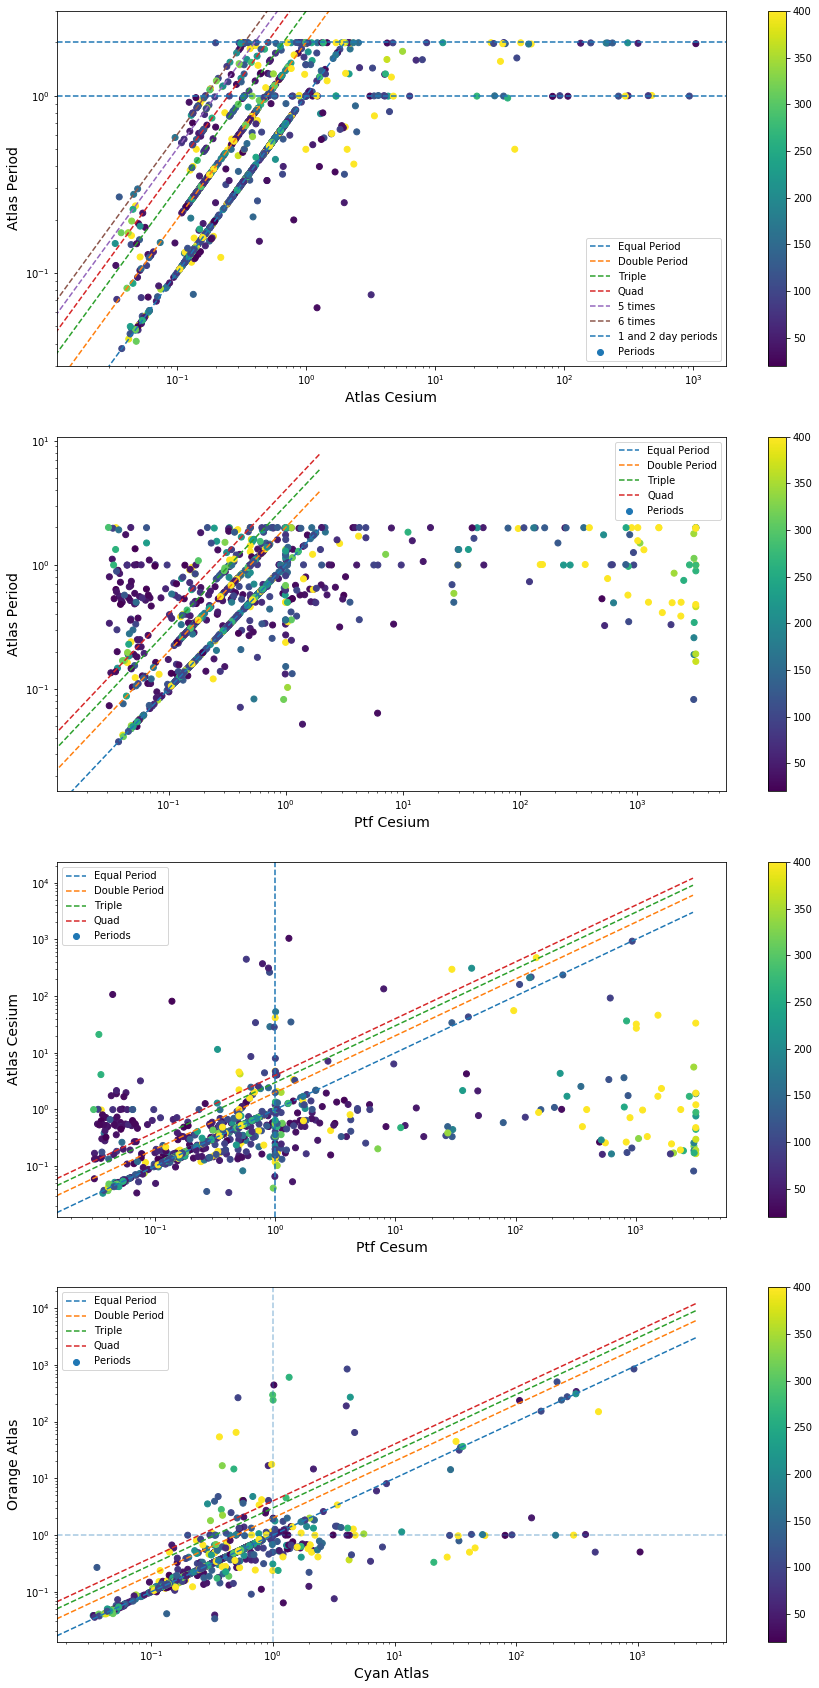

In [349]:
f, ax = plt.subplots(4,1, figsize = (15,30))

x1 = np.linspace(0, 2, 100)
x2 = np.linspace(0, 3000, 100)

cb = ax[0].scatter(perstbl['atlas cesium o'], perstbl['atlas period'], label = 'Periods', \
             c = perstbl['obs'], vmin = 20, vmax = 400)
ax[0].set_ylabel('Atlas Period', fontsize = 14)
ax[0].set_xlabel('Atlas Cesium', fontsize = 14)
ax[0].plot(x1, x1, label = 'Equal Period', ls = '--')
ax[0].plot(x1, 2*x1, label = 'Double Period', ls = '--')
ax[0].plot(x1, 3*x1, label = 'Triple', ls = '--')
ax[0].plot(x1, 4*x1, label = 'Quad', ls = '--')
ax[0].plot(x1, 5*x1, label = '5 times', ls = '--')
ax[0].plot(x1, 6*x1, label = '6 times', ls = '--')
# ax[0].scatter(perstbl[real]['atlas cesium o'][half2], perstbl[real]['atlas period'][half2], \
#               label = '1e-3 Doubles', c = 'r')
ax[0].axhline(y = 1, ls = '--', label = '1 and 2 day periods')
ax[0].axhline(y = 2, ls = '--')
ax[0].set_ylim([0.03, 3])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
plt.colorbar(cb, ax = ax[0])
ax[0].legend()

ax[1].scatter(perstbl['ptf cesium'][real], perstbl['atlas period'][real], label = 'Periods', \
             c = perstbl['obs'][real], vmin = 20, vmax = 400)
ax[1].set_ylabel('Atlas Period', fontsize = 14)
ax[1].set_xlabel('Ptf Cesium', fontsize = 14)
ax[1].plot(x1, x1, label = 'Equal Period', ls = '--')
ax[1].plot(x1, 2*x1, label = 'Double Period', ls = '--')
ax[1].plot(x1, 3*x1, label = 'Triple', ls = '--')
ax[1].plot(x1, 4*x1, label = 'Quad', ls = '--')
# ax[1].scatter(perstbl[real]['ptf cesium'][half], perstbl[real]['atlas period'][half], \
#               label = '1e-3 Doubles', color = 'r')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
plt.colorbar(cb, ax = ax[1])
ax[1].legend()

ax[2].scatter(perstbl['ptf cesium'][real], perstbl['atlas cesium o'][real], label = 'Periods', \
             c = perstbl['obs'][real], vmin = 20, vmax = 400)
ax[2].set_ylabel('Atlas Cesium', fontsize = 14)
ax[2].set_xlabel('Ptf Cesum', fontsize = 14)
ax[2].plot(x2, x2, label = 'Equal Period', ls = '--')
ax[2].plot(x2, 2*x2, label = 'Double Period', ls = '--')
ax[2].plot(x2, 3*x2, label = 'Triple', ls = '--')
ax[2].plot(x2, 4*x2, label = 'Quad', ls = '--')
ax[2].axvline(x = 1, ls = '--')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
plt.colorbar(cb, ax = ax[2])
ax[2].legend()

ax[3].scatter(perstbl['atlas cesium o'], perstbl['atlas cesium c'], label = 'Periods', \
             c = perstbl['obs'], vmin = 20, vmax = 400)
ax[3].set_ylabel('Orange Atlas', fontsize = 14)
ax[3].set_xlabel('Cyan Atlas', fontsize = 14)
ax[3].plot(x2, x2, label = 'Equal Period', ls = '--')
ax[3].plot(x2, 2*x2, label = 'Double Period', ls = '--')
ax[3].plot(x2, 3*x2, label = 'Triple', ls = '--')
ax[3].plot(x2, 4*x2, label = 'Quad', ls = '--')
ax[3].axhline(y = 1, ls = '--', alpha = 0.4)
ax[3].axvline(x = 1, ls = '--', alpha = 0.4)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
plt.colorbar(cb, ax = ax[3])
ax[3].legend()

f.savefig('./periodplots', dpi = 300)

In [34]:
import seaborn as sb

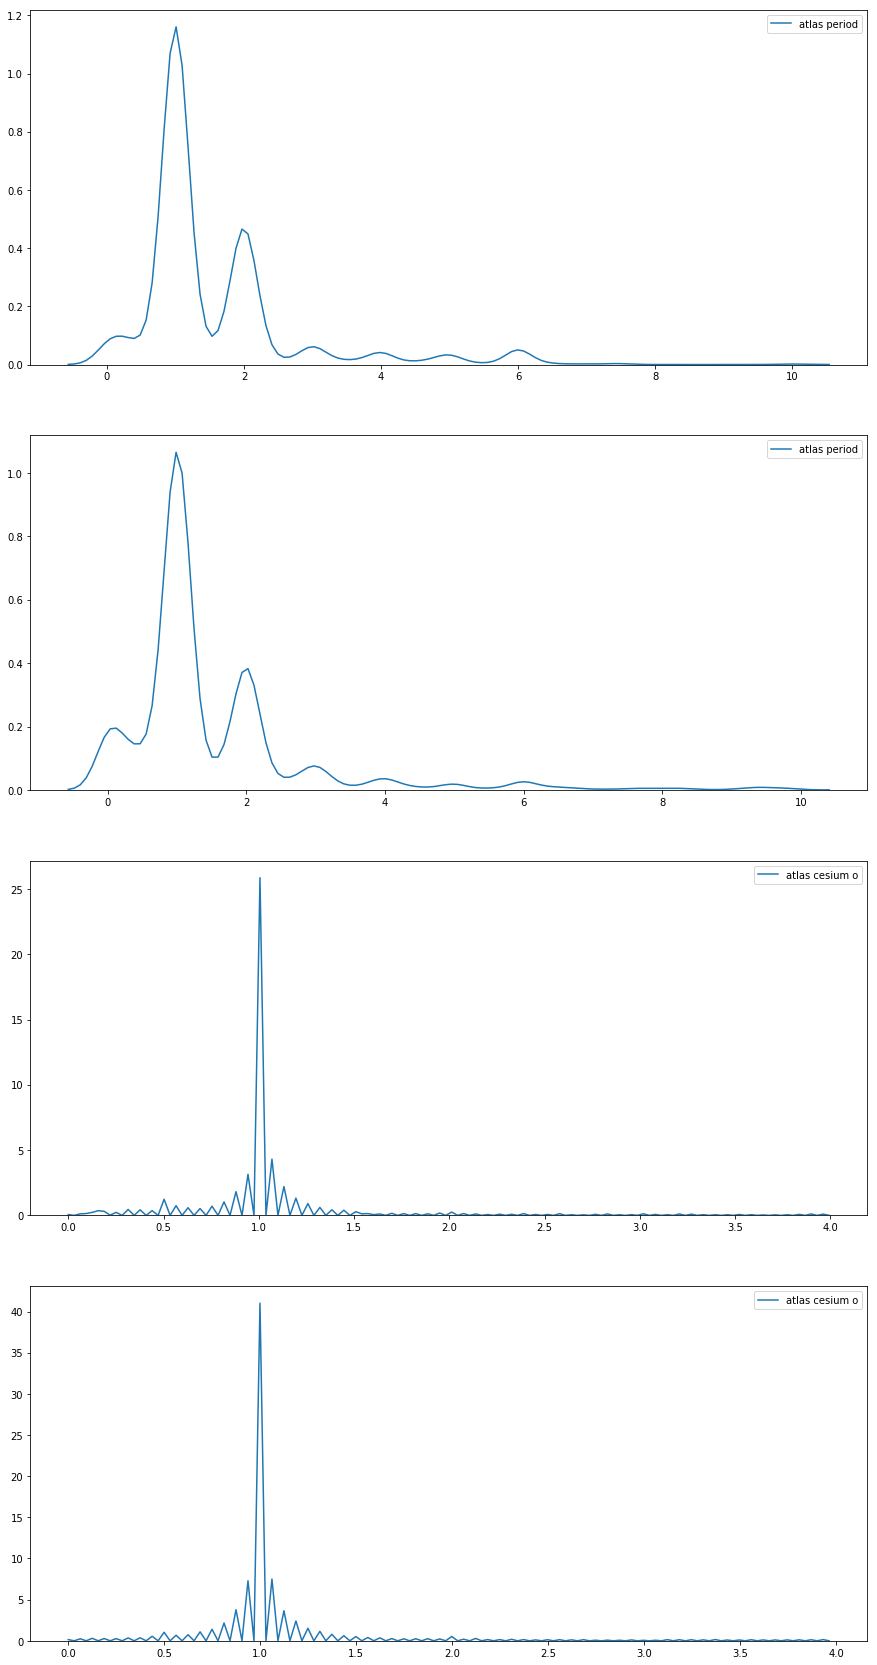

In [41]:
f2, ax2 = plt.subplots(4,1, figsize = (15,30))

sb.kdeplot(perstbl['atlas period']/perstbl['atlas cesium o'], clip = (0,10), ax = ax2[0])

sb.kdeplot(perstbl['atlas period']/perstbl['ptf cesium'], clip = (0,10), ax = ax2[1])

sb.kdeplot(perstbl['atlas cesium o']/perstbl['ptf cesium'], clip = (0,4), ax = ax2[2])

sb.kdeplot(perstbl['atlas cesium o']/perstbl['atlas cesium c'], clip = (0,4), ax = ax2[3])

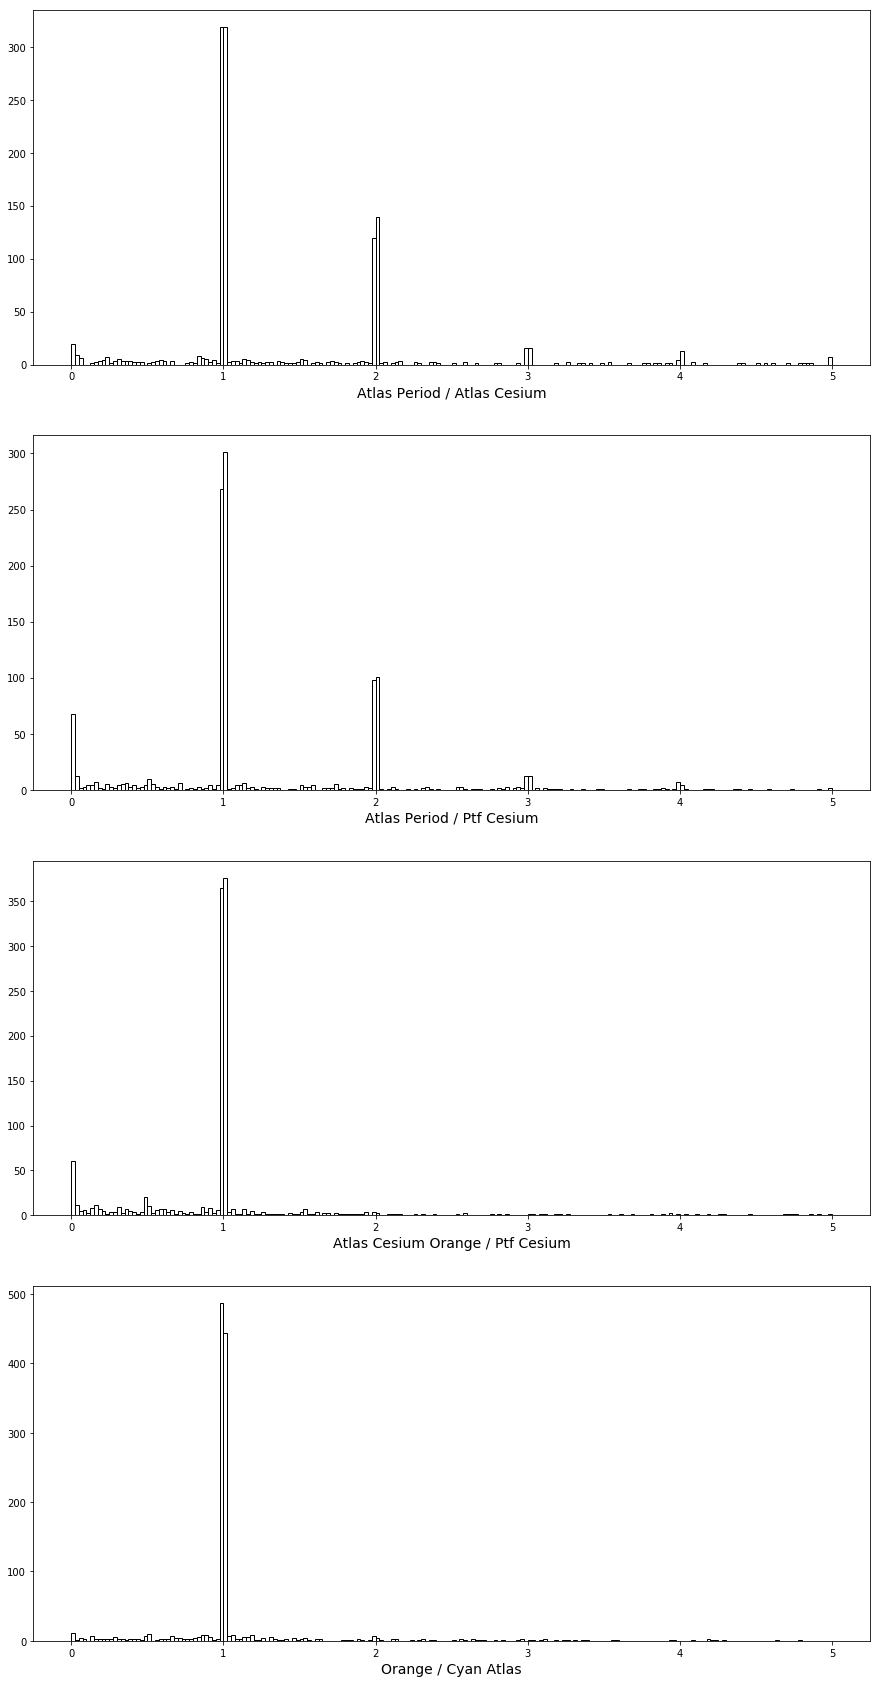

In [33]:
f1, ax1 = plt.subplots(4,1, figsize = (15,30))

h1, c1, i1 = ax1[0].hist(perstbl['atlas period']/perstbl['atlas cesium o'], bins = 200, range = (0,5), fill = False)
ax1[0].set_xlabel('Atlas Period / Atlas Cesium', fontsize = 14)

h2, c2, i2 = ax1[1].hist(perstbl['atlas period'][real]/perstbl['ptf cesium'][real], bins = 200, range = (0,5), fill = False)
ax1[1].set_xlabel('Atlas Period / Ptf Cesium', fontsize = 14)

h3, c3, i3 = ax1[2].hist(perstbl['atlas cesium o'][real]/perstbl['ptf cesium'][real], bins = 200, range = (0,5), fill = False)
ax1[2].set_xlabel('Atlas Cesium Orange / Ptf Cesium', fontsize = 14)

h4, c4, i4 = ax1[3].hist(perstbl['atlas cesium o']/perstbl['atlas cesium c'], bins = 200, range = (0,5), fill = False)
ax1[3].set_xlabel('Orange / Cyan Atlas', fontsize = 14)

f1.savefig('./pershist.png', dpi = 300)

In [9]:
import math

In [14]:
half = []
half2 = []
agree = []

for c in range(len(perstbl['ptf cesium'][real])):
    if math.isclose(2*perstbl['ptf cesium'][real][c], perstbl['atlas period'][real][c], rel_tol = 1e-3):
        half.append(True)
    else:
        half.append(False)
    
    if math.isclose(perstbl['ptf cesium'][real][c], perstbl['atlas period'][real][c], rel_tol = 1e-3):
        agree.append(True)
    else:
        agree.append(False)
        
        
for c in range(len(perstbl['ptf cesium'][real])):
    if math.isclose(2*perstbl['atlas cesium o'][real][c], perstbl['atlas period'][real][c], rel_tol = 1e-3):
        half2.append(True)
    else:
        half2.append(False)

In [252]:
print(f'Number of periods: {len(perstbl)}')
print(f'# Doubled periods: {len(np.array(half2).nonzero()[0])}')
print(f'# Atlas period/Ptf cesium agree: {len(np.array(agree).nonzero()[0])}')

Number of periods: 1244
# Doubled periods: 250
# Atlas period/Ptf cesium agree: 548


(-0.3, 0.6)

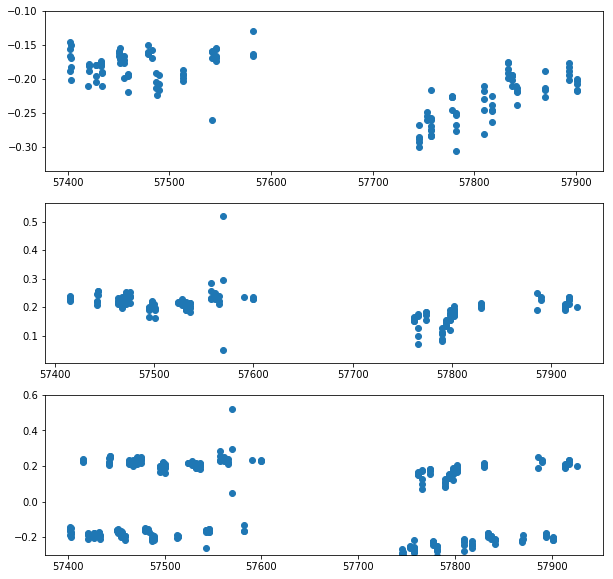

In [199]:
atlwhere = np.where(atlas_lcs['objid'] == 133811890462901167)

fig, axe = plt.subplots(3,1, figsize = (10,10))
for c, filt in enumerate(['c','o']):
    infilt = np.where(atlas_lcs[atlwhere]['filter'] == filt)
    axe[c].scatter(atlas_lcs[atlwhere]['mjd'][infilt], np.mean(atlas_lcs[atlwhere]['m']) - atlas_lcs[atlwhere]['m'][infilt])
    
    
    
axe[2].scatter(atlas_lcs[atlwhere]['mjd'], np.mean(atlas_lcs[atlwhere]['m']) - atlas_lcs[atlwhere]['m'])
axe[2].set_ylim([-.3,.6])

In [227]:
for c, objs in enumerate(np.unique(atlas_lcs['objid'])):
    if (c in rand[20:25]):
#     if (len(ptf_lcs[np.where(ptf_lcs['objid_01'] == objs)]) > 20) and (c in rand):
#     if (c in rand[0:4]) and (len(ptf_lcs[np.where(ptf_lcs['objid_01'] == objs)]) > 20) and \
#         (objs not in [int(string.rsplit('/')[2].rsplit('_')[0]) for string in exist]):
        atlwhere = np.where(atlas_lcs['objid'] == objs)
        ptfwhere = np.where(ptf_lcs['objid_01'] == objs)
   
        #Atlas data with Cesium period
        hjd = np.array(atlas_lcs[atlwhere]["mjd"])
        mag = np.array(atlas_lcs[atlwhere]["m"])
        mag_unc = np.array(atlas_lcs[atlwhere]["dm"])
        filters = np.array(atlas_lcs[atlwhere]['filter'])


        reasonable = np.logical_or((mag < 10),(mag > 23))
        clipped_obs = np.copy(reasonable)
        clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

        #Cesium on Atlas data
        filt = np.where(atlas_lcs[atlwhere][~clipped_obs]['filter'] == 'o')
        cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                               mag[~clipped_obs][filt], 
                                                               mag_unc[~clipped_obs][filt], 
                                                               features_to_use=["freq1_freq", 
                                                                                "amplitude", 
                                                                                "freq1_amplitude1"])

        period_atlces = 1/float(cs_feats["freq1_freq"][0])

        fig4, (ax, ax_phase), (new_ymin, new_ymax) = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
                 period=period_atlces, amp = float(cs_feats['amplitude'][0]))
#         fig4.text(0.5, 0, f"Orange filter cesium' period on Atlas: {period_atlces:.7}", fontsize = 14, horizontalalignment = 'center')
        fig4.text(0.5,1, f'Oid: {objs}', fontsize = 14, horizontalalignment = 'center')
    
        fig4.savefig(f'./newlims_{objs}_fig4.png')

        plt.close(fig4)

In [218]:
objcrit = np.unique(atlas_lcs['objid'])[rand[23]]
atlwhere = np.where(atlas_lcs['objid'] == objcrit)

hjd = np.array(atlas_lcs[atlwhere]["mjd"])
mag = np.array(atlas_lcs[atlwhere]["m"])
mag_unc = np.array(atlas_lcs[atlwhere]["dm"])
filters = np.array(atlas_lcs[atlwhere]['filter'])


reasonable = np.logical_or((mag < 10),(mag > 23))
clipped_obs = np.copy(reasonable)
clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

mean_mag = np.mean(mag)
        
amplitude = np.ptp(mean_mag - mag)
offset = [0.25, -0.25]
raw_ymin = min(mean_mag - mag) - 0.05*amplitude
ymin = min(raw_ymin, np.around(raw_ymin,decimals=2))
raw_ymax = max(mean_mag - mag) + 0.05*amplitude
ymax = max(raw_ymax, np.around(raw_ymax,decimals=2))

print(amplitude, offset, raw_ymin, ymin, raw_ymax, ymax)
amps = np.zeros(2)

for c, filt in enumerate(['c','o']):
    infilt = np.where(atlas_lcs[atlwhere]['filter'] == filt)
    mean_mag = np.mean(mag[infilt])
    amps[c] = np.ptp(mean_mag - mag[infilt])/2
    print(mean_mag, amps[c])
    
new_ymin = ymin + offset[1] * max(amps)
new_ymax = ymax + offset[0] * max(amps)

print(new_ymin, new_ymax)

0.827 [0.25, -0.25] -0.347247810218978 -0.35 0.562452189781022 0.562452189781022
14.96028888888889 0.08800000000000008
14.553848920863308 0.2364999999999995
-0.40912499999999985 0.6215771897810218


In [ ]:
radecp = []

for counter, filename in enumerate(test_lcs):

    ipac_lc = Table.read(filename, format='ipac')

    hjd = np.array(ipac_lc["obsmjd"])
    mag = np.array(ipac_lc["mag_autocorr"])
    mag_unc = np.array(ipac_lc["magerr_auto"])
    
    
    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

    cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                                   mag[~clipped_obs], 
                                                   mag_unc[~clipped_obs], 
                                                   features_to_use=["freq1_freq", 
                                                                    "amplitude", 
                                                                    "freq1_amplitude1"])
    period = 1/float(cs_feats["freq1_freq"][0])
    
    fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
             period=period)
    fig.text(0.1, 0, f"Ra={ipac_lc['ra'][0]}, Dec={ipac_lc['dec'][0]} \nPeriod={period:.4}")
    radecp.append((ipac_lc['ra'][0], ipac_lc['dec'][0], period))

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
test_lcs_csv = glob.glob('./test_lcs/*.csv')
test_lcs_tbl = glob.glob('./test_lcs/*.ipac_tbl')

for counter, filename in enumerate(test_lcs_tbl):
    ipac_lc = Table.read(test_lcs_tbl[counter], format='ipac')
    csv_lc = Table.read(filename, format='csv')
        
    #PTF Plotting
    hjd = np.array(ipac_lc["mjd"][color])
    mag = np.array(ipac_lc["m"][color])
    mag_unc = np.array(ipac_lc["dm"][color])
    
    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
    
    cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                                   mag[~clipped_obs], 
                                                   mag_unc[~clipped_obs], 
                                                   features_to_use=["freq1_freq", 
                                                                    "amplitude", 
                                                                    "freq1_amplitude1"])
    period = 1/float(cs_feats["freq1_freq"][0])
   
    aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period)
    
    #Atlas Plotting
    
    aam_plot()

In [ ]:
test_lcs = glob.glob('./test_lcs/*.csv')


for counter, filename in enumerate(test_lcs):
    ipac_lc = Table.read(filename, format='csv')
    
    c = len(ipac_lc[np.where(ipac_lc['filter'] == 'c')])
    o = len(ipac_lc[np.where(ipac_lc['filter'] == 'o')])
    if c > o:
        color = np.where(ipac_lc['filter'] == 'c')
    else:
        color = np.where(ipac_lc['filter'] == 'o')
        
    hjd = np.array(ipac_lc["mjd"][color])
    mag = np.array(ipac_lc["m"][color])
    mag_unc = np.array(ipac_lc["dm"][color])
    
    
    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
    
#     cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
#                                                    mag[~clipped_obs], 
#                                                    mag_unc[~clipped_obs], 
#                                                    features_to_use=["freq1_freq", 
#                                                                     "amplitude", 
#                                                                     "freq1_amplitude1"])
#     period = 1/float(cs_feats["freq1_freq"][0])
    ind = np.where(np.abs(radecp - ipac_lc['ra'][0]) < .1)[0][0]
    
    fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=radecp[ind][2])
    fig.text(0.1, 0, f"Atlas data \nRa={ipac_lc['ra'][0]}, Dec={ipac_lc['dec'][0]} \nPeriod={ipac_lc['fp_LSperiod'][0]:.4}")
    
    
    
    fig.text(0.7, 0, f"PTF data \nRa={radecp[ind][0]}, Dec={radecp[ind][1]} \nPeriod={radecp[ind][2]:.4}")

In [32]:
def aam_nke_plot(time, mag, mag_unc, filt_id,
             period=1, ptf_filt=2, dpi = 300):
    """Plot a light curve suitable for Zooniverse classification
    """

    color_dict = {1: "LightSeaGreen",
                  2: "Crimson",
                  'c': "DarkTurquoise",
                  'o': "DarkOrange"}

    model_unc = strateva(mag)
    mean_mag = np.mean(mag)
    
    obs_breaks = lc_breaks(time)[0] + 1
    seasons = len(obs_breaks) + 1
    season_dict = {}
    total_obs_duration = 0
    for season_num in range(seasons):
        if season_num == 0:
            season = time[np.argsort(time)][0:obs_breaks[season_num]]
        elif season_num == seasons - 1:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:]
        else:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:obs_breaks[season_num]]

        season_dict["start{:d}".format(season_num)] = min(season)
        season_dict["end{:d}".format(season_num)] = max(season)
        season_dict["length{:d}".format(season_num)] = np.round(np.ptp(season)) + 2
        total_obs_duration += season_dict["length{:d}".format(season_num)]
    

    
    ###### FIGURE #######    
    plot_gap = np.round(0.01*total_obs_duration/(1 - 0.01*len(obs_breaks))).astype(int)

    fig = plt.figure(figsize=(9,6.5))
    
    gs = GridSpec.GridSpec(4, int(total_obs_duration) + len(obs_breaks)*plot_gap)


    amplitude = np.ptp(mean_mag - mag)
    offset = [-0.25, 0.25]
    raw_ymin = min(mean_mag - mag) - 0.05*amplitude
    ymin = min(raw_ymin, np.around(raw_ymin,decimals=2))
    raw_ymax = max(mean_mag - mag) + 0.05*amplitude
    ymax = max(raw_ymax, np.around(raw_ymax,decimals=2))
    if amplitude > 0.5:
        ymajor = np.round(amplitude)/4
        yminor = np.round(amplitude)/20
    elif amplitude < 0.2:
        ymajor = 0.05
        yminor = 0.01
    else:
        ymajor = 0.1
        yminor = 0.02
        
    amps = np.zeros(2)
    new_ymin = 10
    new_ymax = 0

    for c, filt in enumerate(np.unique(filt_id)):
        infilt = np.where(filt_id == filt)
        mean_mag = np.mean(mag[infilt])
        amps[c] = np.ptp(mean_mag - mag[infilt])/2

    for c, filt in enumerate(np.unique(filt_id)):
        infilt = np.where(filt_id == filt)
        mean_mag = np.mean(mag[infilt])

        raw_ymin = min(mean_mag - mag[infilt] + (offset[c] - 0.1) * max(amps))
        new_ymin = min(raw_ymin, np.around(raw_ymin, decimals=2), new_ymin)


        raw_ymax = max(mean_mag - mag[infilt] + (offset[c] + 0.1) * max(amps))
        new_ymax = max(raw_ymax, np.around(raw_ymax,decimals=2), new_ymax)
    
    ###################### Raw ######################   
#     ax_raw = plt.subplot(gs[:,:])
#     for c, filt in enumerate(np.unique(filt_id)):
#         infilt = np.where(filt_id == filt)
#         ax_raw.errorbar(time[infilt]-54900.5, np.mean(mag[infilt]) - mag[infilt] + offset[c] * max(amps), yerr = model_unc[infilt], 
#                          fmt="o", ms=9, mfc=color_dict[filt], 
#                          ecolor=color_dict[ptf_filt], elinewidth=0.5,
#                          mec="0.2", mew=0.2)
#     ax_raw.tick_params(which="both", top=True, right=False,
#                        labelbottom=False, labeltop=True,
#                        labelsize=10)
#     ax_raw.tick_params(axis="x", labelrotation=25, 
#                        labelsize=8, length=5, pad=0)
    
#     ax_raw.xaxis.set_major_locator(MultipleLocator(100))
#     ax_raw.xaxis.set_minor_locator(MultipleLocator(10))
#     ax_raw.set_xticklabels(np.array(ax_raw.get_xticks(), dtype=int), 
#                        ha='left')
    
    
#     ax_raw.yaxis.set_major_locator(MultipleLocator(ymajor))
#     ax_raw.yaxis.set_minor_locator(MultipleLocator(yminor))
#     ax_raw.set_ylabel(r"$\mathrm{Brightness}\,\longrightarrow$", fontsize = 15)
#     ax_raw.set_ylim(new_ymin, new_ymax)
#     fig.text(0.5, 0.05, "Time (d)", 
#               va="bottom", ha="center",
#               transform = ax_raw.transAxes, fontsize = 15)
    
###################### Remove whitespace Curve ######################
        

    for season_num in range(seasons):
        obs_length = season_dict["length{:d}".format(season_num)]
        obs_start = season_dict["start{:d}".format(season_num)]
        obs_end = season_dict["end{:d}".format(season_num)]

        if season_num == 0:
            ax_start = 0
            ax_end = int(obs_length)
        else:
            ax_start = ax_end + plot_gap
            ax_end = ax_start + int(obs_length)
        ax = plt.subplot(gs[0:, ax_start:ax_end])
        ax.set_ylim(ymin,ymax)
        obs_this_season = np.logical_and(time >= obs_start,
                                         time <= obs_end)

        for c, filt in enumerate(np.unique(filt_id[obs_this_season])):
            infilt = np.where(filt_id[obs_this_season] == filt)
            ax.errorbar(time[obs_this_season][infilt] - 54900.5, 
                         np.mean(mag[np.where(filt_id == filt)]) - mag[obs_this_season][infilt] + offset[c] * max(amps), 
                         yerr=model_unc[obs_this_season][infilt], 
                         fmt="o", ms=9, mfc=color_dict[filt], 
                         ecolor=color_dict[filt], elinewidth=0.5,
                         mec="0.2", mew=0.2)
            
        ax.set_xlim(obs_start - 1 - 54900.5, obs_end + 1 - 54900.5)
        ax.tick_params(which="both", top=True, right=False,
                       labelbottom=False, labeltop=True,
                       labelsize=10)
        ax.tick_params(axis="x", labelrotation=25, 
                       labelsize=8, length=5, pad=0)
        
        if obs_length < 10:
            tick_val = np.around(np.floor(obs_start) + np.ceil(obs_length/2) - 54900.5, decimals=0)
            ax.set_xticks([tick_val])
        elif 10 < obs_length < 50:
            tick_val = np.around(obs_start + np.ceil(obs_length/2) - 54900.5, decimals=-1)
            ax.set_xticks([tick_val])
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        elif 50 < obs_length < 200:
            ax.xaxis.set_major_locator(MultipleLocator(50))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        if 200 < obs_length:
            ax.xaxis.set_major_locator(MultipleLocator(100))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), 
                           ha='left')

        
        if season_num == 0:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.set_ylabel(r"$\mathrm{Brightness}\,\longrightarrow$", fontsize = 15)

        elif season_num == seasons-1:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.tick_params(which="both", axis="y", right=True,
                           left=False, labelleft=False)            
        else:
            ax.set_yticks([])
            ax.set_yticks([], minor=True)
        ax.set_ylim(new_ymin, new_ymax)
    fig.text(.5, 0.05, "Time (d)", 
          va="bottom", ha="center",
          transform = ax.transAxes, fontsize = 15)

###################### Phased ######################

#     ax_phase = plt.subplot(gs[:, :])
#     for repeat in [-1, 0, 1]:
#         for c, filt in enumerate(np.unique(filt_id)):
#             infilt = np.where(filt_id == filt)
#             ax_phase.errorbar((time[infilt]/period) % 1 + repeat, 
#                               np.mean(mag[infilt]) - mag[infilt] + offset[c] * max(amps), 
#                               yerr=model_unc[infilt], 
#                               fmt="o", ms=9, mfc=color_dict[ptf_filt], 
#                               ecolor=color_dict[ptf_filt], elinewidth=0.5,
#                               mec="0.2", mew=0.4, alpha=0.95)

#     ax_phase.axvline(x=0, ls='--', color='0.8', lw=1)
#     ax_phase.axvline(x=1, ls='--', color='0.8', lw=1)
#     ax_phase.set_xlim(-0.2,1.2)
#     ax_phase.yaxis.set_major_locator(MultipleLocator(ymajor))
#     ax_phase.yaxis.set_minor_locator(MultipleLocator(yminor))
#     ax_phase.set_ylim(new_ymin,new_ymax)
#     ax_phase.xaxis.set_major_locator(MultipleLocator(0.2))
#     ax_phase.xaxis.set_minor_locator(MultipleLocator(0.05))
#     ax_phase.tick_params(which="both", top=True, right=True, labelsize=11)

#     ax_phase.set_ylabel(r"$\mathrm{Brightness}\,\longrightarrow$", fontsize=15)
#     fig.tight_layout(rect=[.01, .01, 1, 1])
#     ax_phase.set_xlabel(r"$\mathrm{Phase}$", fontsize = 15)
    
#     fig.subplots_adjust(hspace=0.2, top=0.9,right=0.94,left=0.14,bottom=0.11)
#     trans = mtransforms.blended_transform_factory(ax_phase.transData, ax_phase.transAxes)
#     ax_phase.fill_between(np.arange(-0.2,0.01,0.01), 0, 1, alpha = 0.35, facecolor = 'grey', transform = trans)
#     ax_phase.fill_between(np.arange(1,1.21,0.01), 0, 1, alpha = 0.35, facecolor = 'grey', transform = trans)
#     plt.gca().get_xticklabels()[2].set_fontsize(15)
#     plt.gca().get_xticklabels()[2].set_weight('bold')
#     plt.gca().get_xticklabels()[-3].set_fontsize(15)
#     plt.gca().get_xticklabels()[-3].set_weight('bold')
    
    return fig

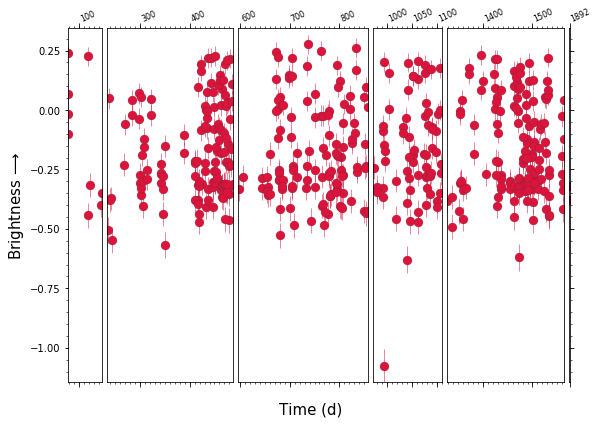

In [33]:
ipac_lc = Table.read('./test_lcs/1000052000008476.ipac_tbl', format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])
filters = np.array(ipac_lc['fid'])


reasonable = np.logical_or((mag < 10),(mag > 23))
clipped_obs = np.copy(reasonable)
clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                               mag[~clipped_obs], 
                                               mag_unc[~clipped_obs], 
                                               features_to_use=["freq1_freq", 
                                                                "amplitude", 
                                                                "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

dpi = 300
fig = aam_nke_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period, filt_id = filters[~clipped_obs])
plt.savefig('./t300_white_1000052000008476.png', dpi = dpi)

In [ ]:
ipac_lc = Table.read('./test_lcs/1000052000004388.ipac_tbl', format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])


reasonable = np.logical_or((mag < 10),(mag > 23))
clipped_obs = np.copy(reasonable)
clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                               mag[~clipped_obs], 
                                               mag_unc[~clipped_obs], 
                                               features_to_use=["freq1_freq", 
                                                                "amplitude", 
                                                                "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

fig = aam_nke_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period, dpi = dpi)
plt.savefig('./ZooMedia/t300_phased_1000052000004388.png', dpi = dpi)

In [5]:
lc = Table.read('xanderout_NickEaston615.csv', format = 'csv')

In [12]:
for c, objs in enumerate(np.unique(lc['ObjID'])):
    atlwhere = np.where(lc['ObjID'] == objs)
    
    #Atlas data with Cesium period
    hjd = np.array(lc[atlwhere]["mjd"])
    mag = np.array(lc[atlwhere]["m"])
    mag_unc = np.array(lc[atlwhere]["dm"])
    filters = np.array(lc[atlwhere]['filter'])


    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
    

    #Cesium on Atlas data
    filt = np.where(lc[atlwhere][~clipped_obs]['filter'] == 'o')
    cs_feats = featurize.featurize_time_series(hjd[~clipped_obs][filt], 
                                                           mag[~clipped_obs][filt], 
                                                           mag_unc[~clipped_obs][filt], 
                                                           features_to_use=["freq1_freq", 
                                                                            "amplitude", 
                                                                            "freq1_amplitude1"])

    period_atlces = 1/float(cs_feats["freq1_freq"][0])

    fig4 = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], filters[~clipped_obs],\
             period=period_atlces)
#         fig4.text(0.5, 0, f"Orange filter cesium' period on Atlas: {period_atlces:.7}", fontsize = 14, horizontalalignment = 'center')
#         fig4.text(0.5,1, f'Oid: {objs}', fontsize = 14, horizontalalignment = 'center')

    fig4.savefig(f'./xanderplots/{objs}.png')

    plt.close(fig4)